In [118]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

> In this notebook, I'll reproduce an optimal control problem solved in the article 'Temporal Discounting of Reward and the Cost of Time in Motor Control', published in 2010 by Shadmehr, Orban de Xivry, Wilson & Shih. The idea is to study saccade movements of the eyes. The plant is modelled as:

$$\begin{pmatrix}
\dot{x}_1 \\
\dot{x}_2 \\
\dot{x}_3
\end{pmatrix} = \begin{pmatrix}
0 & 1 & 0 \\
-\frac{k}{m} & -\frac{b}{m} & \frac{1}{m}\\
0 & 0 & -\frac{\alpha_2}{\alpha_1}
\end{pmatrix}\begin{pmatrix}
x_1\\
x_2\\
x_3
\end{pmatrix}+\begin{pmatrix}0\\0\\ \frac{1}{\alpha_1}
\end{pmatrix} u$$

> The cost that we want to minimize can be written as:
$$J = (\textbf{y}^{(p)}-\textbf{r})^T T (\textbf{y}^{(p)}-\textbf{r}) + \textbf{u}_h^T L \textbf{u}_h + \alpha \left(1-\frac{1}{1+\beta p}\right)$$

> In order to minimize this cost, first we must select an arbitrary length of time $p$ and find the optimal set of motor commandes $\textbf{u}^*_h(p)$ that minimize $J$. The solution is given as:

$$\textbf{u}_h^*(p) = (L+\Gamma^T F^T C^T T C F \Gamma)^{-1}\Gamma^T F^T C^T T(\textbf{r}_h-C A^p \textbf{x}^{(0)})$$

>  Finally, we can use the following discrete equation to find the velocities at each time step:

$$\textbf{x}^{(p)}=A^k \textbf{x}^{(0)}+\sum_{j=0}^{k-1}A^{k-1-j}\textbf{b}u^{(j)}$$

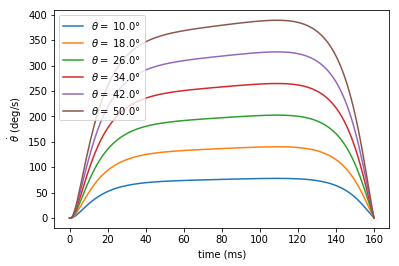

In [119]:
def uopt(p):
    F=[]
    for t in range(0,p):
        F.insert(0,np.linalg.matrix_power(A,t))
    F=np.block(F)

    G=np.kron(np.eye(p), B)

    GFTrans=np.matmul(G.transpose(),F.transpose())
    GFT=np.matmul(GFTrans,T)
    FG=np.matmul(F,G)
    GFTFG=np.matmul(GFT,FG)
    Inv=np.linalg.inv(np.identity(p)+GFTFG)

    InvGFT=np.matmul(Inv,GFT)

    Apx0=np.matmul(np.linalg.matrix_power(A,p),x0)

    u=np.matmul(InvGFT,r-Apx0)
    
    return(u)


k=1.0
tau1=0.224
tau2=0.013
b=tau1+tau2
m=tau1*tau2
alpha2=1.0
alpha1=0.004
nu1=5.0E9
nu2=1.0E6
nu3=80.0
p=160
dt=0.160/p

T = [[nu1,0,0],
     [0,nu2,0],
     [0,0,nu3]]

x0 = [[0],
      [0],
      [0]]

A  = [[0,1,0],
      [-k/m,-b/m,1/m],
      [0,0,-alpha2/alpha1]]

A = np.multiply(A,dt)+np.identity(3)

B  = [[0],
      [0],
      [1/alpha1]]

B  = np.multiply(B,dt) 


amplitude = np.linspace(10,50,6)
for amp in amplitude:
    r = [[amp*pi/180],
         [0],
         [0]]

    u=uopt(p)
    velocity=[0.0]
    for k in range(1,p+1):
        summ=0
        for j in range(0,k):
            summ+=np.matmul(np.linalg.matrix_power(A,k-1-j),B)*u[j,0]
        xk=np.matmul(np.linalg.matrix_power(A,k),x0)+summ
        velocity.append(xk[1,0])
    
    plt.plot(np.linspace(0,160,p+1),[v*180/pi for v in velocity],label=r"$\theta =$ "+str(amp)+'°')

plt.xlabel("time (ms)")
plt.ylabel(r"$\dot{\theta}$ (deg/s)")
plt.legend()
plt.show()

# Adding some noise (and some trouble)

> Now we must consider some Gaussian noise $\varepsilon^{(k)} = \mathcal{N}(0,\kappa^2 \left(u^{(k)}\right)^2)=\frac{1}{\sqrt{2\pi}\kappa u^{(k)}}e^{-\frac{k^2}{2\kappa^2 u^{2}}}$.

$$\textbf{x}^{(k+1)}=A \textbf{x}^{(k)}+\textbf{b}(u^{(k)}+\varepsilon^{(k)})$$

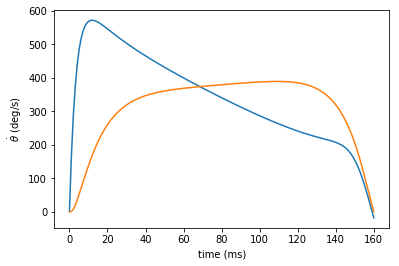

In [130]:
k=1.0
tau1=0.224
tau2=0.013
b=tau1+tau2
m=tau1*tau2
alpha2=1.0
alpha1=0.004
nu1=5.0E9
nu2=1.0E6
nu3=80.0
p=160
dt=0.160/p
kappa=0.009

r = [[50*pi/180],
     [0],
     [0]]


T = [[nu1,0,0],
     [0,nu2,0],
     [0,0,nu3]]

x0 = [[0],
      [0],
      [0]]

A  = [[0,1,0],
      [-k/m,-b/m,1/m],
      [0,0,-alpha2/alpha1]]

A = np.multiply(A,dt)+np.identity(3)

B  = [[0],
      [0],
      [1/alpha1]]

B  = np.multiply(B,dt) 

ui=uopt(p)

eps=[]

for k in range(p):
    epsilonk =(1/(np.sqrt(2*pi)*kappa*ui[k])*np.exp(-(k)**2/(2*kappa**2*ui[k]**2)))[0]
    eps.append(epsilonk)
  
epsilon=np.reshape(eps, (len(eps), 1))

F=[]
for t in range(0,p):
    F.insert(0,np.linalg.matrix_power(A,t))
F=np.block(F)
G=np.kron(np.eye(p), B)

GFTrans=np.matmul(G.transpose(),F.transpose())
GFT=np.matmul(GFTrans,T)
FG=np.matmul(F,G)
GFTFG=np.matmul(GFT,FG)

S = np.diag(GFTFG)
S = np.diag(S)

Inv=np.linalg.inv(np.identity(p)+GFTFG+np.multiply(kappa**2,S))
InvGFT=np.matmul(Inv,GFT)
Apx0=np.matmul(np.linalg.matrix_power(A,p),x0)
u=np.matmul(InvGFT,r-Apx0)
velocity2=[]
xk=x0
for k in range(0,p):
    xkp1=np.matmul(A,xk)+np.multiply(B,(u[k,0]+epsilon[k,0]))
    velocity2.append(xkp1[1,0])
    xk=xkp1
    
plt.plot(np.linspace(0,160,p),[v*180/pi for v in velocity2])
plt.plot(np.linspace(0,160,p+1),[v*180/pi for v in velocity])  #previous plot without noise
plt.plot()
plt.xlabel("time (ms)")
plt.ylabel(r"$\dot{\theta}$ (deg/s)")
plt.show()